In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.metrics
from sklearn.model_selection import train_test_split
import math
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import os
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

%load_ext autoreload
%autoreload 2
from NNFunctions import *

## Load Data

In [2]:
x_train = pd.read_csv('./Data with correct player_atts/x_train.csv')
x_val = pd.read_csv('./Data with correct player_atts/x_val.csv')
x_test = pd.read_csv('./Data with correct player_atts/x_test.csv')

y_train = pd.read_csv('./Data with correct player_atts/y_train.csv')
y_val = pd.read_csv('./Data with correct player_atts/y_val.csv')
y_test = pd.read_csv('./Data with correct player_atts/y_test.csv')

x_train.shape, x_val.shape, x_test.shape

((14611, 53), (1376, 53), (1383, 53))

In [3]:
print('Train B365 log_loss: {}'.format(log_loss(y_train.target, x_train[[ 'B365H','B365D', 'B365A']])))
print('Val B365 log_loss: {}'.format(log_loss(y_val.target, x_val[[ 'B365H', 'B365D', 'B365A']])))
print('Test B365 log_loss: {}'.format(log_loss(y_test.target, x_test[[ 'B365H', 'B365D', 'B365A']])))

Train B365 log_loss: 0.9751891448037668
Val B365 log_loss: 0.9566483812081246
Test B365 log_loss: 0.9665172728104048


## Initialise Models

In [6]:

input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 3

model_dict = {

'model4': LinearNN(5, (input_size,output_size), [128,256,128,32,16], nn.ReLU(), 0.5),
'model5': LinearNN(5, (input_size,output_size), [128,512,256,128,32], nn.ReLU(), 0.5),
'model6': LinearNN(5, (input_size,output_size), [64,512,256,128,32], nn.ReLU(), 0),
'model7': LinearNN(6, (input_size,output_size), [128,256,256,128,32,16], nn.ReLU(), 0.5),
'model8': LinearNN(6, (input_size,output_size), [64,256,256,128,64,32], nn.ReLU(), 0),
'model9': LinearNN(6, (input_size,output_size), [256,512,512,128,32,16], nn.ReLU(), 0.5),
'model10': LinearNN(7, (input_size,output_size), [64,256,256,128,32,16,8], nn.ReLU(), 0.5),
'model11': LinearNN(7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0),
'model12': LinearNN(7, (input_size,output_size), [256,512,128,64,32,16,8], nn.ReLU(), 0.5),
'model13': LinearNN(8, (input_size,output_size), [64,128,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(8, (input_size,output_size), [128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(8, (input_size,output_size), [256,512,512,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(9, (input_size,output_size), [64,128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(9, (input_size,output_size), [128,256,256,128,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(9, (input_size,output_size), [256,512,512,256,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(10, (input_size,output_size), [64,128,256,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(10, (input_size,output_size), [128,256,256,512,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(10, (input_size,output_size), [256,512,512,256,256,128,32,16,8,8], nn.ReLU(), 0.5),
}

In [6]:

input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 3

model_dict = {

'model4': LinearNN(5, (input_size,output_size), [128,256,128,32,16], nn.ReLU(), 0.5),
'model5': LinearNN(5, (input_size,output_size), [128,512,256,128,32], nn.ReLU(), 0.5),
'model6': LinearNN(5, (input_size,output_size), [64,512,256,128,32], nn.ReLU(), 0),
'model7': LinearNN(6, (input_size,output_size), [128,256,256,128,32,16], nn.ReLU(), 0.5),
'model8': LinearNN(6, (input_size,output_size), [64,256,256,128,64,32], nn.ReLU(), 0),
'model9': LinearNN(6, (input_size,output_size), [256,512,512,128,32,16], nn.ReLU(), 0.5),
'model10': LinearNN(7, (input_size,output_size), [64,256,256,128,32,16,8], nn.ReLU(), 0.5),
'model11': LinearNN(7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0),
'model12': LinearNN(7, (input_size,output_size), [256,512,128,64,32,16,8], nn.ReLU(), 0.5),
'model13': LinearNN(8, (input_size,output_size), [64,128,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(8, (input_size,output_size), [128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(8, (input_size,output_size), [256,512,512,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(9, (input_size,output_size), [64,128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(9, (input_size,output_size), [128,256,256,128,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(9, (input_size,output_size), [256,512,512,256,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(10, (input_size,output_size), [64,128,256,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(10, (input_size,output_size), [128,256,256,512,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(10, (input_size,output_size), [256,512,512,256,256,128,32,16,8,8], nn.ReLU(), 0.5),
}

## Train Models

In [4]:
input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 3

model_dict = {

#'model4': LinearNN(5, (input_size,output_size), [128,256,128,32,16], nn.ReLU(), 0.2),
'6_layer_1': LinearNN('6_layer_1', 6, (input_size,output_size), [512,256,128,64,32,8], nn.ReLU(), 0.2),
'6_layer_2': LinearNN('6_layer_2', 6, (input_size,output_size), [512,256,128,64,32,8], nn.ReLU(), 0.2),
'6_layer_3': LinearNN('6_layer_3', 6, (input_size,output_size), [512,256,128,64,32,8], nn.ReLU(), 0.2),

#'model10': LinearNN('model10', 7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0.3),
#'model17': LinearNN('model17', 6, (input_size,output_size), [128,512,256,128,32,16], nn.ReLU(), 0.6),
#'model20': LinearNN('model20', 7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0.6),
# 'model11': LinearNN(7, (input_size,output_size), [128,256,512,256,64,16,8], nn.ReLU(), 0.2),
 #'model12': LinearNN('model12',8, (input_size,output_size), [256,512,512,256,128,64,16,8], nn.ReLU(), 0.6),
# 'model13': LinearNN('model13', 9, (input_size,output_size), [128,128,256,256,128,64,32,16,8], nn.ReLU(), 0.3),
#'model14': LinearNN('model14', 9, (input_size,output_size), [128,512,256,256,128,64,32,16,8], nn.ReLU(), 0.6),

#'model15': LinearNN('model15',8, (input_size,output_size), [256,512,512,256,128,64,16,8], nn.ReLU(), 0.7),
    #'model16': LinearNN('model16', 9, (input_size,output_size), [256,512,256,256,128,64,32,16,8], nn.ReLU(), 0.6)
}

##delete previous checkpoints
remove_existing_checkpoints(model_dict)


In [ ]:
results = train_many(model_dict, x_train, y_train, batch_size = 1024 , epochs = 2, learning_rate = 0.001, use_scheduler=True, scheduler_step_size=25, change_trainset=True)
results


6_layer_1
Loss after iteration 0: 1.1056773662567139
.  
6_layer_2
Loss after iteration 0: 1.1012169122695923


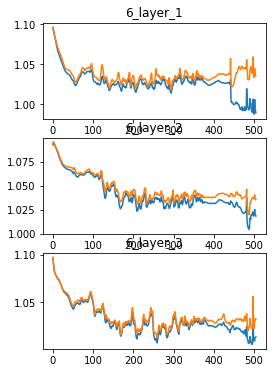

In [252]:
plot_losses(model_dict)

In [60]:
directory_str = './NN Models/'
directory = os.fsencode(directory_str)

load_dict = {}
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    if filename.endswith(".pt"): 
        filename = os.fsdecode(file)
        load_dict[filename] = torch.load(directory_str+filename)




model12_7_31.pt
model16.pt
model16_7_31.pt
model17_7_31.pt
model7.pt
model7_7_31.pt


In [239]:
## Ensemble learning
dictionary = model_dict
is_models = False
use_odds = True

scaler = preprocessing.StandardScaler().fit(x_train.iloc[:,1:])
x_ens = get_ens_df(x_train, scaler, dictionary, is_models=is_models, use_odds=use_odds)
x_ens_val = get_ens_df(x_val, scaler, dictionary, is_models=is_models, use_odds=use_odds)
x_ens_test = get_ens_df(x_test, scaler, dictionary, is_models=is_models, use_odds=use_odds)


RF_clf = RandomForestClassifier(max_depth=3, random_state=0, n_estimators = 100)
RF_clf.fit(x_ens, y_train['target'])

print('Models:{}'.format(list(dictionary.keys())))
print('Train Accuracy: {}'.format(RF_clf.score(x_ens, y_train['target'])))
print('Val Accuracy: {}'.format(RF_clf.score(x_ens_val, y_val['target'])))
print('Train log loss: {}'.format(log_loss(y_train['target'], RF_clf.predict_proba(x_ens))))
print('Val log loss: {}'.format(log_loss(y_val['target'], RF_clf.predict_proba(x_ens_val))))
#print('Test log loss: {}'.format(log_loss(y_test['target_binary'], RF_clf.predict_proba(x_ens_test))))

print('\nTrain B365 Accuracy: {}'.format(accuracy_score(y_train.target, np.array(x_train[[ 'B365H','B365D', 'B365A']]).argmax(axis=1))))
print('Val B365 Accuracy: {}'.format(sklearn.metrics.accuracy_score(y_val.target, np.array(x_val[[ 'B365H','B365D', 'B365A']]).argmax(axis=1))))
print('Train B365 log_loss: {}'.format(log_loss(y_train.target, x_train[[ 'B365H','B365D', 'B365A']])))
print('Val B365 log_loss: {}'.format(log_loss(y_val.target, x_val[[ 'B365H','B365D', 'B365A']])))


Models:['6_layer_1', '6_layer_2', '6_layer_3']
Train Accuracy: 0.5929094517829033
Val Accuracy: 0.5181686046511628
Train log loss: 0.9230832454854859
Val log loss: 0.9751504536654775

Train B365 Accuracy: 0.5281637122715762
Val B365 Accuracy: 0.5494186046511628
Train B365 log_loss: 0.9751891448037668
Val B365 log_loss: 0.9566483812081246


In [240]:
r = permutation_importance(RF_clf, x_ens_val, y_val['target'],
                           n_repeats=30,
                  random_state=0)

a = zip(x_ens.columns, r.importances_mean)
pd.DataFrame(a).sort_values(by = 1, ascending = False)

,0,1
0,6_layer_1_0,0.009569
2,6_layer_1_2,0.003731
7,6_layer_3_1,0.000654
6,6_layer_3_0,0.000363
4,6_layer_2_1,0.000218
3,6_layer_2_0,0.000145
11,B365A,0.000097
10,B365D,-0.000073
9,B365H,-0.000073
8,6_layer_3_2,-0.000606


In [218]:
dictionary = model_dict
is_models = False


scaler = preprocessing.StandardScaler().fit(x_train.iloc[:,1:])
x_ens = get_ens_df(x_train, scaler, dictionary, is_models=is_models)
x_ens_val = get_ens_df(x_val, scaler, dictionary, is_models=is_models)

Logistic_clf = LogisticRegression(random_state=0, C = 1).fit(x_ens,  y_train['target'])
print('Models:{}'.format(list(dictionary.keys())))
print('Train Accuracy: {}'.format(Logistic_clf.score(x_ens, y_train['target'])))
print('Val Accuracy: {}'.format(Logistic_clf.score(x_ens_val, y_val['target'])))
print('Train log loss: {}'.format(log_loss(y_train['target'], Logistic_clf.predict_proba(x_ens))))
print('Val log loss: {}'.format(log_loss(y_val['target'], Logistic_clf.predict_proba(x_ens_val))))

print('\nTrain B365 Accuracy: {}'.format(accuracy_score(y_train.target, np.array(x_train[[ 'B365H','B365D', 'B365A']]).argmax(axis=1))))
print('Val B365 Accuracy: {}'.format(sklearn.metrics.accuracy_score(y_val.target, np.array(x_val[[ 'B365H','B365D', 'B365A']]).argmax(axis=1))))
print('Train B365 log_loss: {}'.format(log_loss(y_train.target, x_train[[ 'B365H','B365D', 'B365A']])))
print('Val B365 log_loss: {}'.format(log_loss(y_val.target, x_val[[ 'B365H','B365D', 'B365A']])))

C:\Users\Jack.Dai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Models:['6_layer_1', '6_layer_2', '6_layer_3']
Train Accuracy: 0.6805146807200054
Val Accuracy: 0.4992732558139535
Train log loss: 0.7788080087903564
Val log loss: 1.167861039179416

Train B365 Accuracy: 0.5281637122715762
Val B365 Accuracy: 0.5494186046511628
Train B365 log_loss: 0.9751891448037668
Val B365 log_loss: 0.9566483812081246


In [736]:
ensemble_predict_simple([model_dict[x].model for x in model_dict], x_val, y_val, scaler)

Ensemble accuracy: 0.6416464891041163


In [114]:
save_models(model_dict.keys(), model_dict)